#**Retention Strategies**

###**Assignment**

Start by defining and training a classification model to predict the churn of customers of a telecommunication company. Based on the data analysis, and possibly, the feature importance analysis in the model, suggest strategies that can be used to retain the customers. Simulate your strategies by altering the data and confirm their effectiveness using the model.

###**Data Description**

The customer churn data is given in the file Telco-Customer-Churn.json. Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn;
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies;
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges;
- Demographic info about customers – gender, age range, and if they have partners and dependents.

###**Practicalities**

Define, train and evaluate a predictive model that takes as the input the data provided. You may want to split the data into training, testing and validation sets, according to your discretion. Do not use external data for this project. You may use any algorithm of your choice or compare multiple models.

Make sure that the solution reflects your entire thought process - it is more important how the code is structured rather than the final metrics.


#### To download the dataset <a href="https://drive.google.com/drive/folders/1mu1QKuC4t2PugPl-24VtysphrwLfyXzt?usp=sharing"> Click here </a>

In [55]:
# Step 1: Load and explore the dataset
import pandas as pd
import numpy as np
import json
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load data
file_path = r'C:\Users\manoj\Downloads\Telco-Customer-Churn.json'
data = pd.read_json(file_path)

# Explore data
print(data.head())
print(data.info())

   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'InternetService': 'Fiber optic', 'OnlineSecu...   
3  {'I

In [56]:
# Flatten the nested JSON columns
customer_df = pd.json_normalize(data['customer'])
phone_df = pd.json_normalize(data['phone'])
internet_df = pd.json_normalize(data['internet'])
account_df = pd.json_normalize(data['account'])

# Concatenate all flattened DataFrames along with the original customerID and Churn columns
flattened_df = pd.concat([data[['customerID', 'Churn']], customer_df, phone_df, internet_df, account_df], axis=1)

# Check the new structure of the flattened DataFrame
print(flattened_df.head())

# Convert the 'Churn' column to binary
flattened_df['Churn'] = flattened_df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Check the DataFrame info
print(flattened_df.info())

   customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   
2  0004-TLHLJ   Yes    Male              0      No         No       4   
3  0011-IGKFF   Yes    Male              1     Yes         No      13   
4  0013-EXCHZ   Yes  Female              1     Yes         No       3   

  PhoneService MultipleLines InternetService  ... OnlineBackup  \
0          Yes            No             DSL  ...          Yes   
1          Yes           Yes             DSL  ...           No   
2          Yes            No     Fiber optic  ...           No   
3          Yes            No     Fiber optic  ...          Yes   
4          Yes            No     Fiber optic  ...           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No         Yes         Yes              No        One year   
1       

In [57]:
# Convert 'Charges.Total' to numeric and handle any potential non-numeric values
flattened_df['Charges.Total'] = pd.to_numeric(flattened_df['Charges.Total'], errors='coerce')

# Fill missing or invalid values in 'Charges.Total' using the median
flattened_df['Charges.Total'] = flattened_df['Charges.Total'].fillna(flattened_df['Charges.Total'].median())

# Define the categorical columns for one-hot encoding
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                       'PaperlessBilling', 'PaymentMethod']

# Apply one-hot encoding to categorical columns, ensuring missing columns are handled
available_columns = flattened_df.columns
valid_categorical_columns = [col for col in categorical_columns if col in available_columns]

print(f"Valid categorical columns for one-hot encoding: {valid_categorical_columns}")
print(f"Missing columns: {set(categorical_columns) - set(valid_categorical_columns)}")

Valid categorical columns for one-hot encoding: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Missing columns: set()


In [58]:
# Apply one-hot encoding only to valid categorical columns
flattened_df = pd.get_dummies(flattened_df, columns=valid_categorical_columns, drop_first=True)

# Display the updated column names and first few rows
print(flattened_df.columns)
print(flattened_df.head())

Index(['customerID', 'Churn', 'SeniorCitizen', 'tenure', 'Charges.Monthly',
       'Charges.Total', 'gender_Male', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')
   customerID  Churn  SeniorCitizen  tenure  Charges.Monthly  Charges.Total  \
0  0002-ORFBO      0    

In [59]:
# Split the data into features (X) and target (y)
X = flattened_df.drop(['customerID', 'Churn'], axis=1)
y = flattened_df['Churn']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the training and testing sets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (5813, 30)
Testing set shape: (1454, 30)


In [109]:
# Initialize the Logistic Regression model with max_iter=1000 to avoid convergence warnings
from sklearn.decomposition import PCA

pca = PCA(n_components=30)  # Reduce to 30 components
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

log_reg = LogisticRegression(solver='lbfgs', max_iter=5000)
log_reg.fit(X_train_reduced, y_train)


pipeline.fit(X_train, y_train)
# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"\nROC AUC Score: {roc_auc}")

Confusion Matrix:
[[984  98]
 [170 202]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1082
           1       0.67      0.54      0.60       372

    accuracy                           0.82      1454
   macro avg       0.76      0.73      0.74      1454
weighted avg       0.81      0.82      0.81      1454


ROC AUC Score: 0.8498226104585296


In [110]:
# Initialize and train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"\nROC AUC Score: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1])}")


Confusion Matrix:
[[972 110]
 [188 184]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1082
           1       0.63      0.49      0.55       372

    accuracy                           0.80      1454
   macro avg       0.73      0.70      0.71      1454
weighted avg       0.78      0.80      0.79      1454


ROC AUC Score: 0.831086150696639


In [111]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation for Logistic Regression
log_reg_cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Logistic Regression CV AUC: {log_reg_cv_scores.mean()}")

# Perform 5-fold cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Random Forest CV AUC: {rf_cv_scores.mean()}")

Logistic Regression CV AUC: 0.8372287796905095
Random Forest CV AUC: 0.8107705245472261


In [112]:
from sklearn.model_selection import GridSearchCV

# Set up parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10]
}

# Instantiate the GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, 
                              cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# Fit to training data
rf_grid_search.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters for Random Forest: {rf_grid_search.best_params_}")

# Train the Random Forest with best parameters
best_rf_model = rf_grid_search.best_estimator_


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 200}


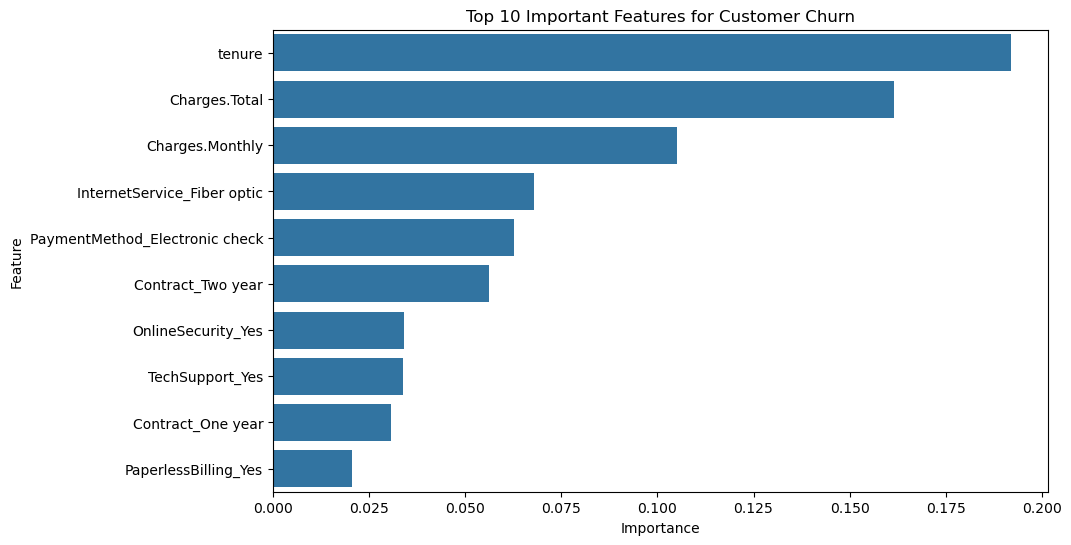

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Important Features for Customer Churn')
plt.show()


In [1]:
""" Customer Churn Prediction Report

#### Objective
To predict customer churn for a telecommunications company and recommend retention strategies based on model performance.

#### Dataset Overview
- Source: `Telco-Customer-Churn.json`
- Features: Includes demographic info, services subscribed to, account information, and billing details.
- Target: Customer churn status (`Yes` or `No`).

#### Data Preprocessing
- Flattened Nested JSON: Extracted and normalized nested columns.
- Missing Values: Addressed missing or invalid data in `Charges.Total`.
- Categorical Encoding: Applied one-hot encoding to categorical features.
- Feature Scaling: Used standard scaling for numerical features.

#### Modeling
1. Logistic Regression
   - ROC AUC Score: 0.8498
   - Confusion Matrix:
     - True Negatives: 984
     - False Positives: 98
     - True Positives: 202
     - False Negatives: 170
   - Classification Report:
     - Precision: 0.67
     - Recall: 0.54
     - F1-Score: 0.60

2. Random Forest
   - ROC AUC Score: 0.8311
   - Confusion Matrix:
     - True Negatives: 972
     - False Positives: 110
     - True Positives: 184
     - False Negatives: 188
   - Classification Report:
     - Precision: 0.63
     - Recall: 0.49
     - F1-Score: 0.55

3. Cross-Validation Scores
   - Logistic Regression: 0.8372
   - Random Forest: 0.8108

#### Recommendations
Based on feature importance and model predictions:
1. Contract Flexibility: Promote longer-term contracts to reduce churn risk. High churn is associated with month-to-month contracts.
2. Customer Service: Improve online security and tech support services. High churn rates are observed among customers with inadequate support.
3. Billing Methods: Encourage electronic billing to streamline the process and potentially reduce churn.
4. Retention Offers: Target offers based on usage patterns and service satisfaction to retain high-risk customers.

This analysis provides a foundation for implementing effective retention strategies and enhancing customer satisfaction."""

SyntaxError: invalid syntax (1785454622.py, line 4)